# <p style="text-align:center;"><span style="font-size:48px;"><span style="color:#d9fd05;"><span style="font-family:cursive;"> Resignation Probability Prediction</span> </span>  </span></p>

![image](https://www.beswicks.com/wp-content/uploads/2019/07/Disciplinary-proceedings-blog-2-Jul19.jpg)

<h2>🎯 Project Objective</h2>
<p>Predict the likelihood of employee resignation to help HR improve retention strategies.</p>
    

<h2>📊 Dataset Insights</h2>
Each row represents an employee with features like:
  <ul>
        <li>Satisfaction level</li>
        <li>Last evaluation score</li>
        <li>Number of projects</li>
        <li>Average monthly hours</li>
        <li>Time spent at the company</li>
        <li>Work accidents</li>
        <li>Promotions in last 5 years</li>
        <li>Department</li>
        <li>Salary level</li>
    </ul>

Target variable: 'left' (0: stayed, 1: resigned)

<h2>🧠 Our Approach</h2>
    <ol>
        <li>Data Preprocessing & Exploratory Analysis</li>
        <li>Feature Engineering & Selection</li>
        <li>Model Comparison (CatBoost, XGBoost, LightGBM)</li>
        <li>Performance Evaluation (Accuracy, AUC)</li>
        <li>Feature Importance Visualization</li>
        <li>Interactive Prediction Interface</li>
    </ol>

<h2>⚖️ Ethical Considerations</h2>
This model is a tool to assist HR, not to make decisions. It should be used as part of a comprehensive, employee-centric approach to improve workplace satisfaction and retention.
<h2>🚀 What's Next?</h2>
Dive into the code to see how we tackle this real-world HR challenge with data science!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from ipywidgets import widgets
from IPython.display import display, clear_output
from IPython.display import HTML, display


In [2]:
df = pd.read_csv('/kaggle/input/regresion-probability/HR.csv')

In [3]:
print("HR Analytics: Employee Attrition Prediction")
print("Explore the dataset and predict employee attrition")

print("\nData Overview")
display(df.head())
display(df.describe())


HR Analytics: Employee Attrition Prediction
Explore the dataset and predict employee attrition

Data Overview


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


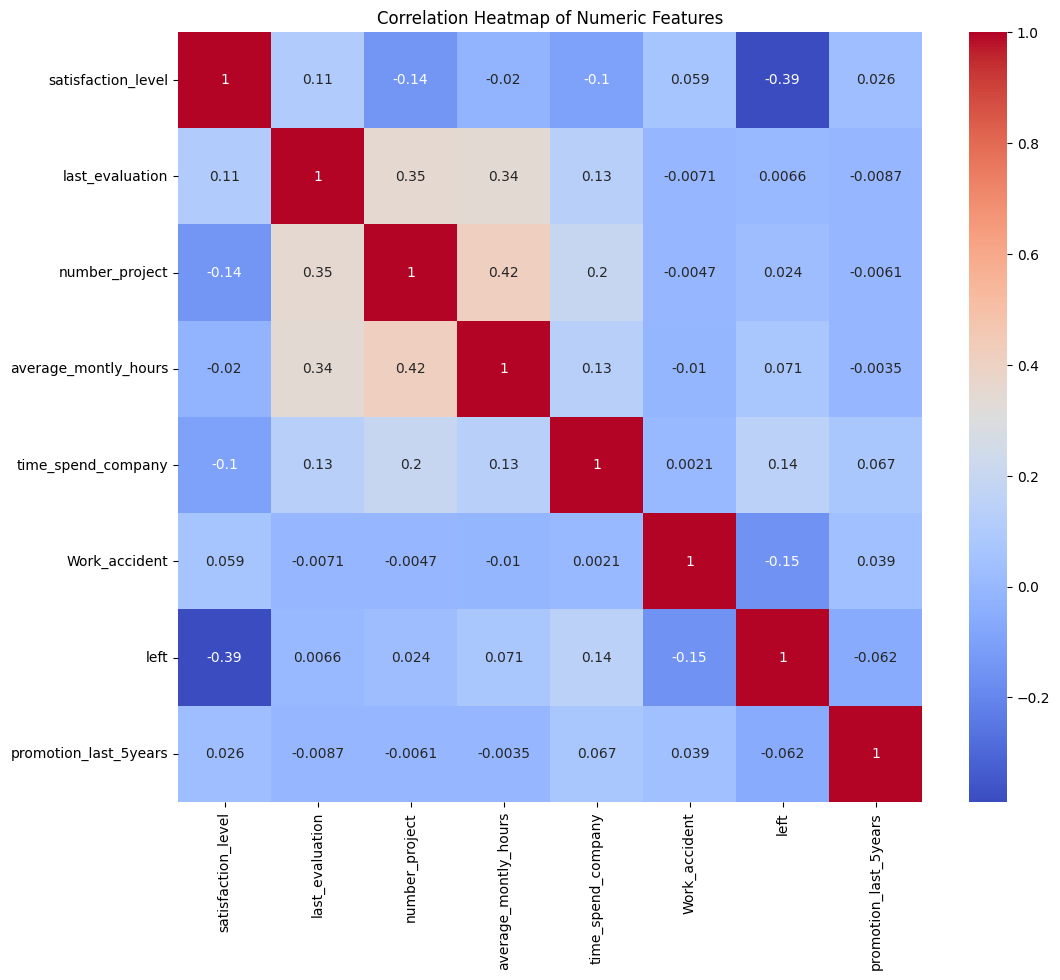

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Distribution of Employee Attrition


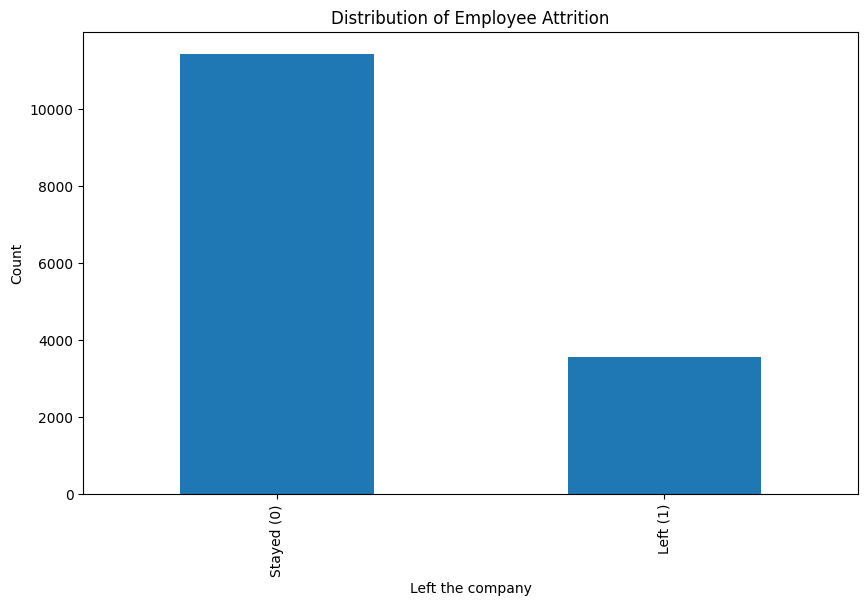

In [5]:
# Distribution of target variable
print("Distribution of Employee Attrition")
plt.figure(figsize=(10, 6))
df['left'].value_counts().plot(kind='bar')
plt.title("Distribution of Employee Attrition")
plt.xlabel("Left the company")
plt.ylabel("Count")
plt.xticks([0, 1], ['Stayed (0)', 'Left (1)'])
plt.show()

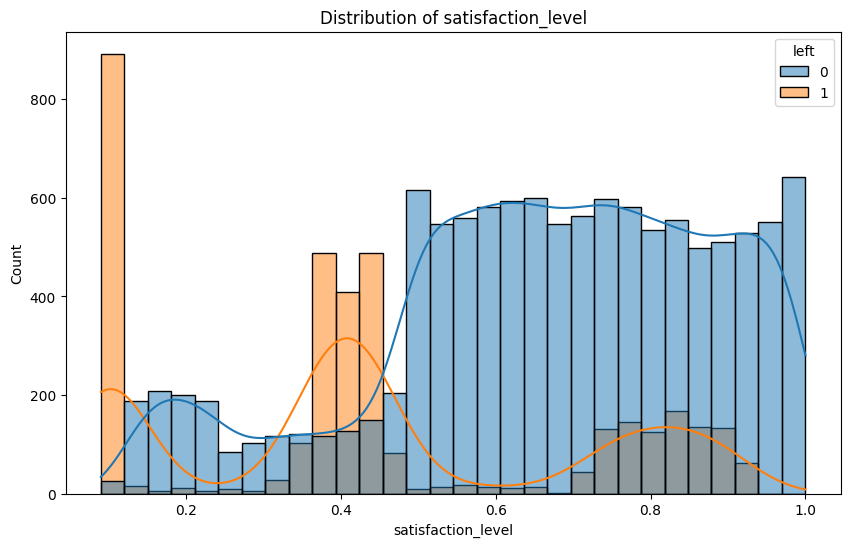

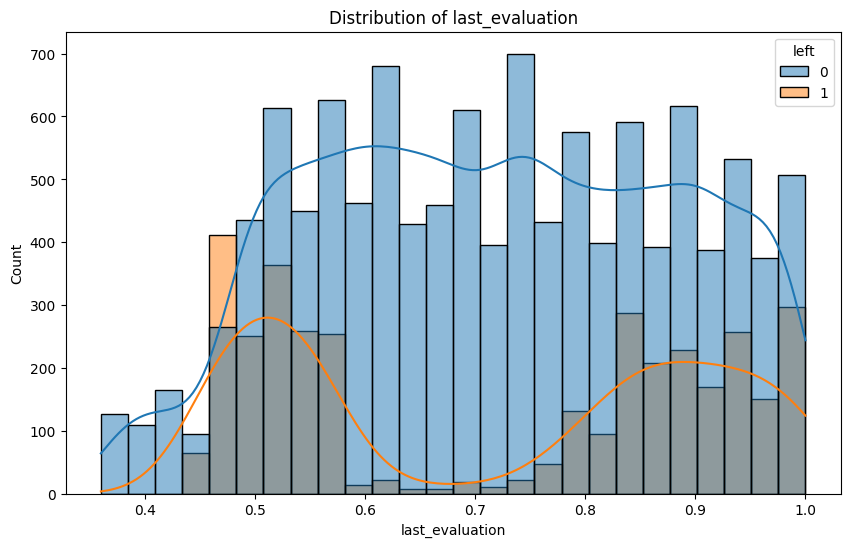

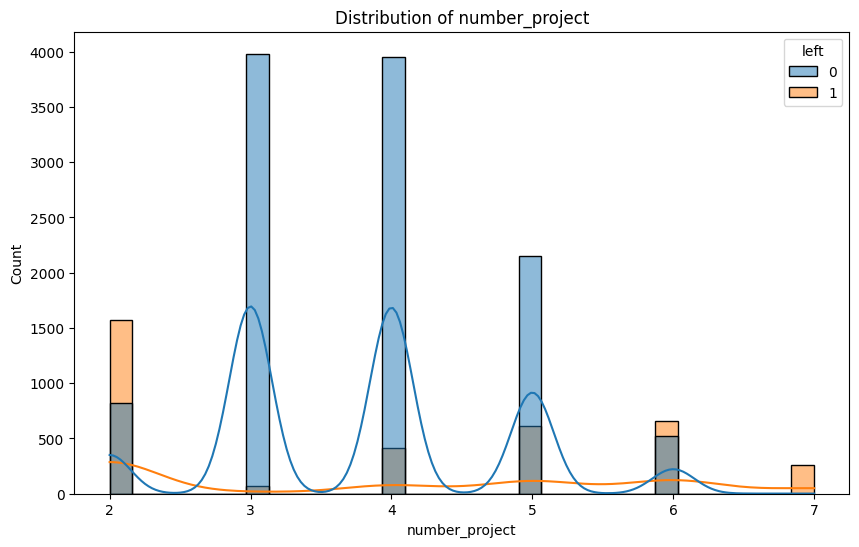

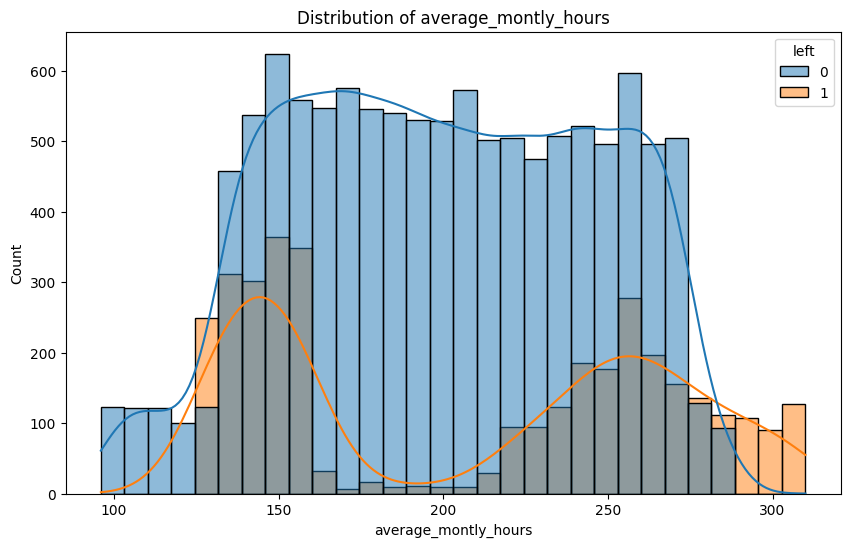

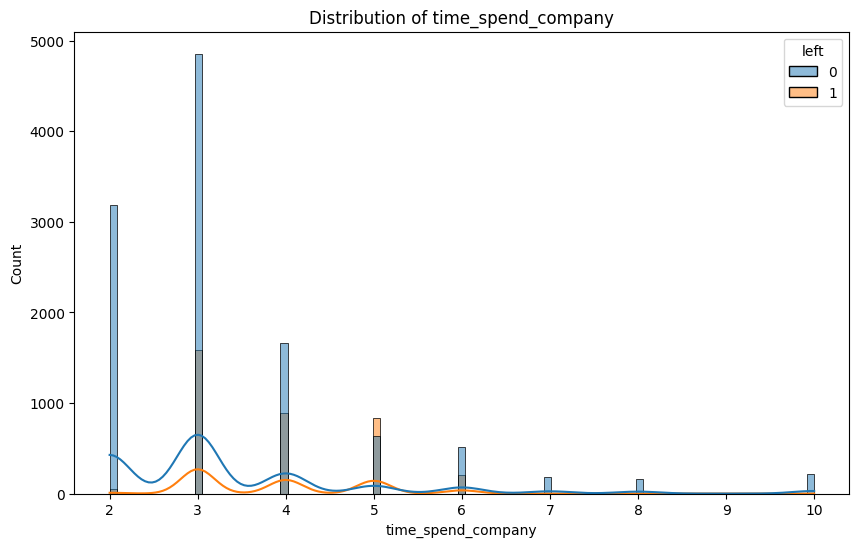

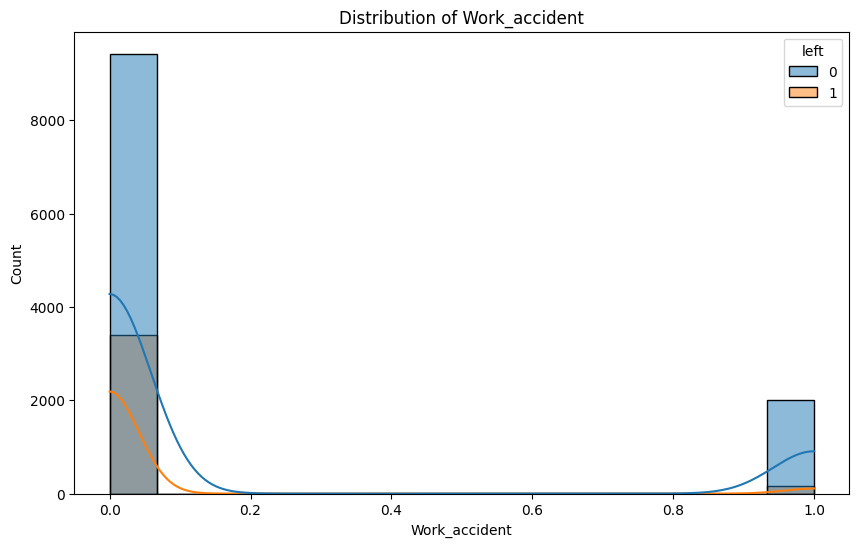

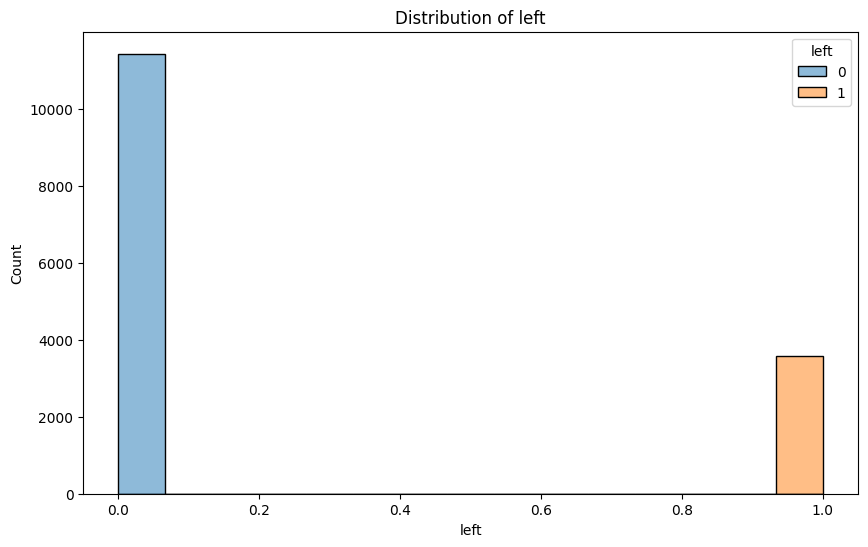

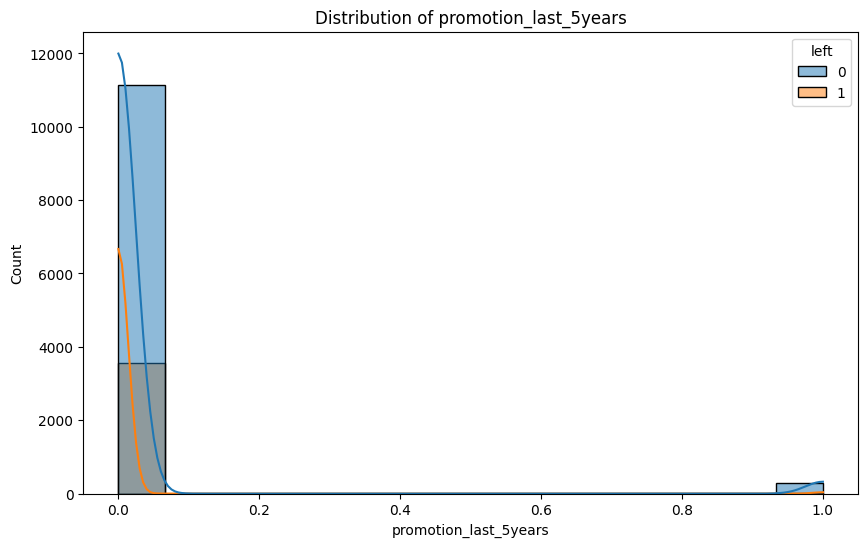

In [6]:
# Feature distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='left', kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [7]:
def preprocess_data(df):
    # Separate features and target
    X = df.drop('left', axis=1)
    y = df['left'].astype(int)  # Ensure target is integer type
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X[numeric_columns] = imputer.fit_transform(X[numeric_columns])
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_columns = ['sales', 'salary']
    for col in categorical_columns:
        X[col] = le.fit_transform(X[col])
    
    # Feature engineering
    X['workload'] = X['average_montly_hours'] / X['number_project']
    X['tenure_performance'] = X['time_spend_company'] * X['last_evaluation']
    
    # Normalize numerical features
    scaler = StandardScaler()
    X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
    
    return X, y, le

# Apply preprocessing
X, y, le = preprocess_data(df)

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# perform feature selection only on the training data
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=11)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=11)

In [10]:
# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales', 'salary', 'workload',
       'tenure_performance'],
      dtype='object')


In [11]:
# Transform both train and test data using the fitted RFE
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

In [12]:
# Create DataFrames with selected features
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

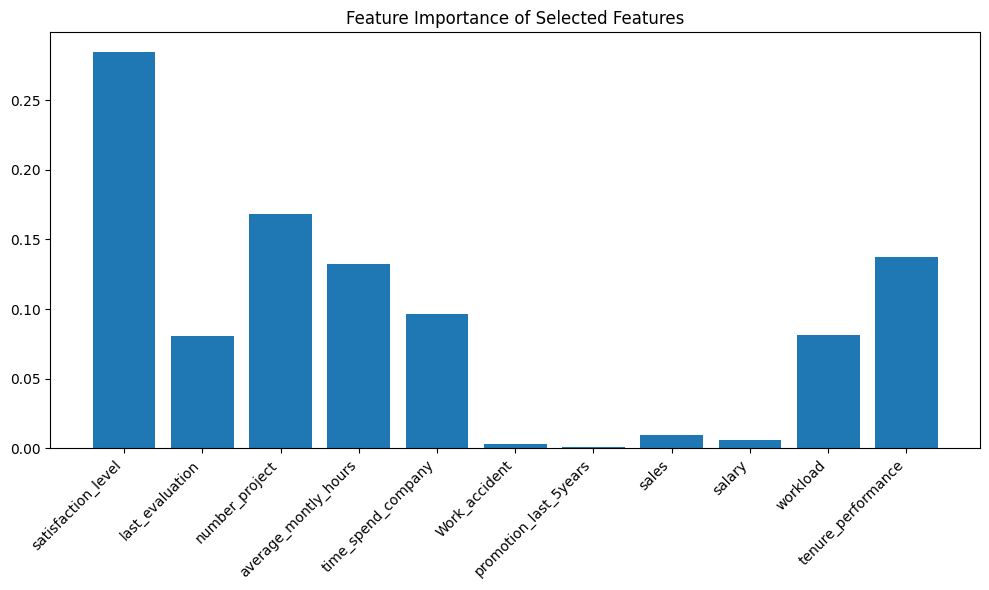

In [13]:
#visualize the selected features
plt.figure(figsize=(10, 6))
plt.bar(selected_features, rfe.estimator_.feature_importances_[rfe.support_])
plt.title('Feature Importance of Selected Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Model training and comparison
models = {
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0),
    "XGBoost": XGBClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1])
    results[name] = {"Accuracy": accuracy, "AUC": auc}

print("Model Comparison")
results_df = pd.DataFrame(results).T
print(results_df)

Model Comparison
          Accuracy       AUC
CatBoost  0.985333  0.991867
XGBoost   0.988333  0.991388
RF        0.989000  0.990759


<Figure size 1000x600 with 0 Axes>

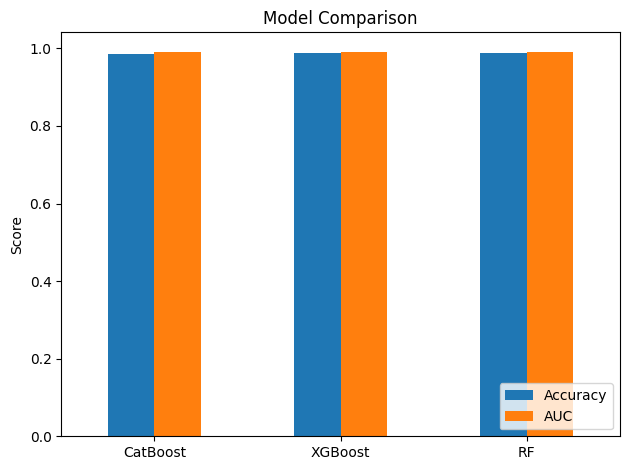

In [15]:
# Visualize model comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
# Select the best model (highest AUC)
best_model_name = results_df['AUC'].idxmax()
best_model = models[best_model_name]

print(f"Best model: {best_model_name}")


Best model: CatBoost


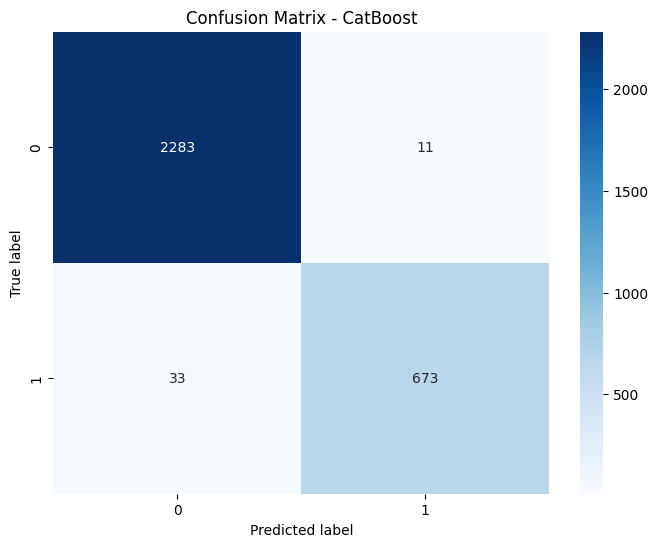

In [17]:
# Confusion Matrix for the best model
y_pred = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

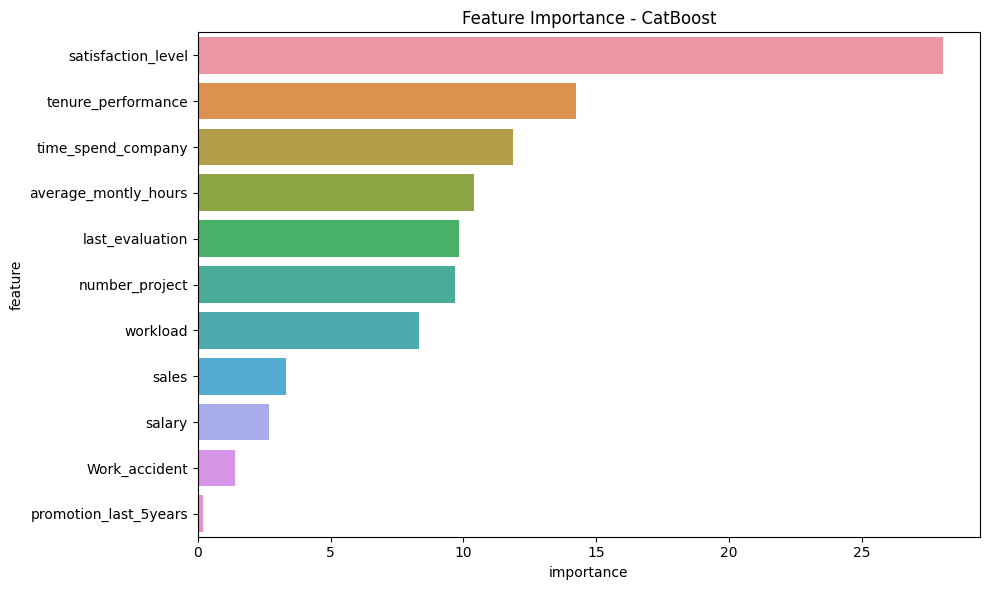

In [18]:
# Feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

In [19]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [20]:
# Save the best model
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

In [21]:
def create_input_widgets():
    return {
        'satisfaction_level': widgets.FloatText(description='Satisfaction (0-1):'),
        'last_evaluation': widgets.FloatText(description='Last Evaluation (0-1):'),
        'number_project': widgets.IntText(description='Projects:'),
        'average_montly_hours': widgets.IntText(description='Monthly Hours:'),
        'time_spend_company': widgets.IntText(description='Years in Company:'),
        'Work_accident': widgets.Checkbox(description='Work Accident'),
        'promotion_last_5years': widgets.Checkbox(description='Promoted in 5 Years'),
        'sales': widgets.Text(description='Department:'),
        'salary': widgets.Dropdown(options=['low', 'medium', 'high'], description='Salary:')
    }

def predict_with_button(b):
    employee_data = {key: widget.value for key, widget in input_widgets.items()}
    resignation_probability = predict_resignation(employee_data)
    
    clear_output(wait=True)
    display(widgets.VBox(list(input_widgets.values()) + [predict_button, output]))
    
    with output:
        print(f"\nThe probability of the employee resigning is: {resignation_probability:.2f}")
        
        if resignation_probability < 0.3:
            print("Low risk of attrition")
        elif resignation_probability < 0.7:
            print("Moderate risk of attrition")
        else:
            print("High risk of attrition")

# Create input widgets
input_widgets = create_input_widgets()

# Create the predict button
predict_button = widgets.Button(description="Predict Attrition")
predict_button.on_click(predict_with_button)

# Create an output widget to display results
output = widgets.Output()

# Display the widgets and button
display(widgets.VBox(list(input_widgets.values()) + [predict_button, output]))

In [22]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


***1.*** **Data Preprocessing: Handling missing values, encoding categorical variables, and feature scaling.**

***2.*** **Exploratory Data Analysis: Visualizing data distributions and correlations.**

***3.*** **Feature Engineering: Creating new features to capture more information from the existing data.**

***4.*** **Feature Selection: Using Recursive Feature Elimination to select the most important features.**

***5.*** **Model Comparison: Training and evaluating multiple machine learning models.**

***6.*** **Model Evaluation: Using appropriate metrics (Accuracy and AUC) to assess model performance.**

***7.*** **Interpretability: Visualizing feature importance to understand what drives the predictions.**

***8.*** **Deployment: Creating a user-friendly interface for making predictions using IPython widgets.**

***Key findings:***

**- The most important features for predicting employee attrition are 1.satisfaction_level 2.tenure_performance 3.time_spend_company.**

**- Catboost performed the best, achieving an AUC of best AUC score.**